<a href="https://colab.research.google.com/github/faheem-khaskheli/tensorflow_basics/blob/main/Siamese_Network_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Flatten, Dropout, Lambda
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
def create_pairs(x, digit_indices):
  '''Positive and negative pair creation
  Alternates between positive and negative pairs.
  '''
  pairs = []
  labels = []
  n = min([len(digit_indices[d]) for d in range(10)]) -1

  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, 10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1, 0]
  
  return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')
  return pairs, y

In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [ ]:
train_images = X_train.reshape(60000, 28, 28, 1)
test_images = X_test.reshape(10000, 28, 28, 1)

train_images = train_images/255
test_images = test_images/255
train_images = train_images.astype('float')
test_images = test_images.astype('float')

train_labels = Y_train
test_labels = Y_test

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [ ]:
def show_img(img):
  plt.figure()
  img = np.array(img, dtype='float')
  img = img.reshape((28, 28))
  plt.imshow(img)
  plt.colorbar() 
  plt.grid(False)
  plt.show()

0.0


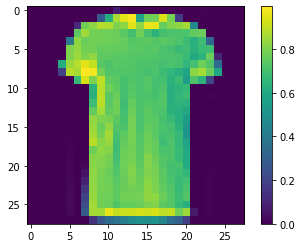

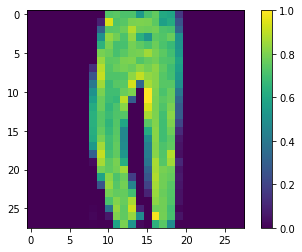

In [ ]:
this_pair = 9

show_img(tr_pairs[this_pair][0])
show_img(tr_pairs[this_pair][1])

print(tr_y[this_pair])

In [ ]:
def initialize_base_network():
  input = Input(shape=(28, 28), name="base_input")
  x = Flatten(name="flatten_image")(input)
  x = Dense(128, activation='relu', name='first_base_dense')(x)
  x = Dropout(0.1, name='first_dropout')(x)
  x = Dense(128, activation='relu', name='second_base_dense')(x)
  x = Dropout(0.1, name='second_dropout')(x)
  x = Dense(128, activation='relu', name='third_base_dense')(x)
  return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shape):
  shape1, shape2 = shapes
  return (shape1[0], 1)

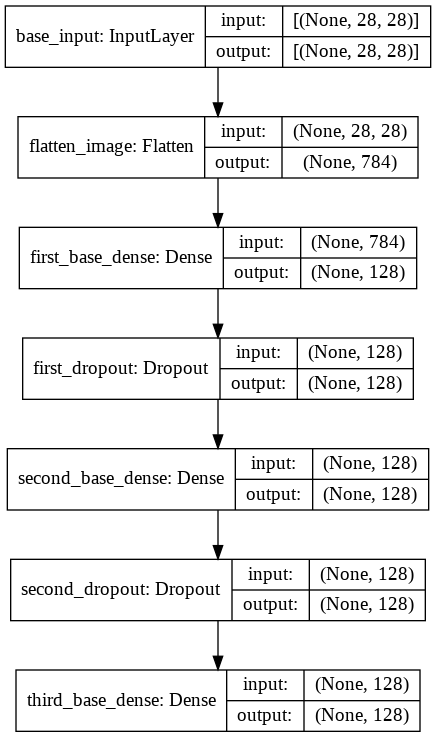

In [ ]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model1.png')

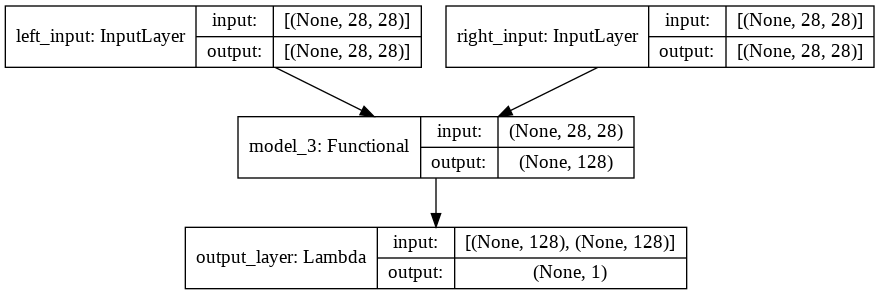

In [ ]:
input_a = Input(shape=(28, 28), name='left_input')
vect_output_a = base_network(input_a)
input_b = Input(shape=(28, 28), name='right_input')
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, 
                name='output_layer', 
                output_shape=eucl_dist_output_shape)([vect_output_a,
                                                      vect_output_b])
model = Model([input_a, input_b], output)

plot_model(model, show_shapes=True, show_layer_names=True,)

In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), 
              optimizer=rms)
history = model.fit([tr_pairs[:, 0],
                    tr_pairs[:, 1]],
                    tr_y, 
                    epochs=20,
                    batch_size=1128,
                    validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

loss = model.evaluate(x=[ts_pairs[:, 0], ts_pairs[:, 1]], y=ts_y)

Epoch 1/20
107/107 [==============================] - 6s 46ms/step - loss: 0.2680 - val_loss: 0.1032
Epoch 2/20
107/107 [==============================] - 5s 43ms/step - loss: 0.1052 - val_loss: 0.0899
Epoch 3/20
107/107 [==============================] - 5s 44ms/step - loss: 0.0886 - val_loss: 0.0829
Epoch 4/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0797 - val_loss: 0.0790
Epoch 5/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0736 - val_loss: 0.0721
Epoch 6/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0695 - val_loss: 0.0713
Epoch 7/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0655 - val_loss: 0.0661
Epoch 8/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0615 - val_loss: 0.0653
Epoch 9/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0600 - val_loss: 0.0655
Epoch 10/20
107/107 [==============================] - 5s 43ms/step - loss: 0.0579 - val_lo

In [ ]:
def compute_accuracy(y_true, y_pred):
  pred = y_pred.ravel() > 0.5
  return np.mean(pred == y_true)

In [ ]:
y_pred_train = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:, 0], ts_pairs[:, 1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuacy = {}".format(loss,
                                                                train_accuracy,
                                                                test_accuracy))

Loss = 0.06225471571087837, Train Accuracy = 0.057767961326887815 Test Accuacy = 0.08173173173173173


[0.16672006249427795, 0.10056165605783463, 0.08655624836683273, 0.07824458926916122, 0.07251060754060745, 0.06795249879360199, 0.06467684358358383, 0.061826907098293304, 0.059469617903232574, 0.05753907561302185, 0.05593358725309372, 0.054625678807497025, 0.053199123591184616, 0.05204141139984131, 0.05138707906007767, 0.05005234107375145, 0.04932069405913353, 0.048432230949401855, 0.04773908481001854, 0.04712137579917908]
[0.10320266336202621, 0.08989352732896805, 0.08292330056428909, 0.07895995676517487, 0.07211708277463913, 0.07130421698093414, 0.06607382744550705, 0.06532531976699829, 0.0654967799782753, 0.06795699894428253, 0.06666535139083862, 0.06518593430519104, 0.06705942749977112, 0.06335470825433731, 0.062287844717502594, 0.06250183284282684, 0.06447505950927734, 0.06638328731060028, 0.06410150974988937, 0.0622546449303627]


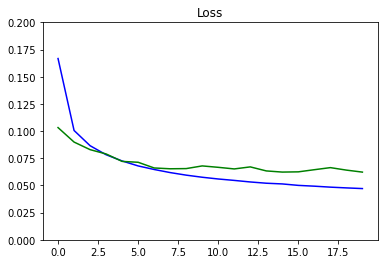

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  print(history.history[metric_name])
  print(history.history["val_"+metric_name])
  plt.plot(history.history[metric_name], 
           color='blue', 
           label=metric_name)
  plt.plot(history.history['val_' + metric_name], 
           color='green',
           label='val_' + metric_name)
  plt.show()

plot_metrics(metric_name='loss', title='Loss', ylim=0.2)

In [ ]:
def visualize_images():
  plt.rc('image', cmap='gray_r')
  plt.rc('grid', linewidth=0)
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('ytick', top=False, bottom=False, labelsize='large')
  plt.rc('axes', facecolor='F8F8F8', titlesize='large', edgecolor='white')
  plt.rc('text', color='a8151a')
  plt.rc('figure', facecolor='F0F0F0')

In [ ]:
def display_images(left, right, predictions, labels, title, n):
  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.xticks([])
  plt.yticks([])
  plt.grid(None)

  left = np.reshape(left, [n, 28, 28])
  left = np.swapaxes(left, 0, 1)
  left = np.reshape(left, [28, 28*n])

  plt.imshow(left)
  plt.figure(figsize=(17,3))
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.yticks([])

  for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] > 0.5: 
      t.set_color('red')
    else:
      t.set_color('blue')
  plt.grid(None)

  right = np.reshape(right, [n, 28, 28])
  right = np.swapaxes(right, 0, 1)
  right = np.reshape(right, [28, 28*n])
  plt.imshow(right)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


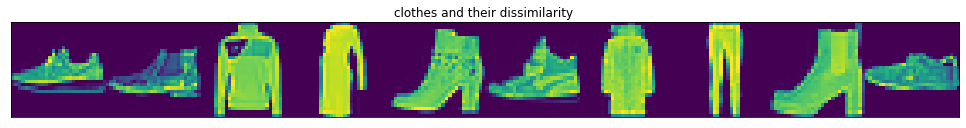

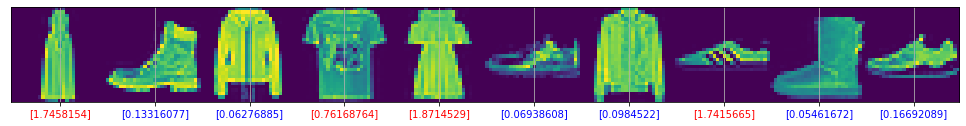

In [ ]:
pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes],
               tr_pairs[:, 1][indexes],
               y_pred_train[indexes],
               tr_y[indexes],
               'clothes and their dissimilarity ', 10)